
# Overview of the Golden Bullet
## Mission
To predict the movement of stocks with an above 80% success rate. 
I will first start with long term, unidimentional, "stable" stocks – e.g. blue chips – and then evolve to more ad hoc, multidimentional, "volital" stocks – e.g. penny stocks, ETFs, futures, etc.


Much of this work will be utilizing concepts from Boris https://github.com/borisbanushev/stockpredictionai/blob/f1984b952b86d61653758ddcd0dc6dd3735a5e5b/TradingAI.ipynb


pmdARIMA Stock Prediction
https://alkaline-ml.com/pmdarima/usecases/stocks.html
- here's the notebook pmdARIMA Stock Prediction
https://github.com/alkaline-ml/pmdarima/blob/master/examples/stock_market_example.ipynb

Stock MAarket Prediction TOWARDS DATASCIENCE 
https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a


Different approach, uses transformers instead - pinklion, mean varience optimization 
https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6

Series where Oleg Kazanski progresses the model (this is part 3)
https://medium.com/@GenerousDataAnalyst/75-accuracy-stocks-prediction-based-on-financial-kpis-92ba83177346

Full XGBOOST stratagy
https://python.plainenglish.io/algorithmic-trading-with-python-strategy-2-xgboost-regression-model-prediction-of-future-9aff9743ae2e#755d




## Workflow
    Initial Phase
    1. Get simple data – prices, high-lows, etc. on the Goldmann Sachs (NYSE:GS) common stock
    
    2. Clean data and prepare it for predictions
    
    3. Use CatBoost to predict the stock prices of a previous year (1.e. 2021)
    
    4. Evaluate: cross-validate, feature importance, param tuning, etc.
    
   
    Intermediate Phase
    5. Rerun the pipeline but with more features delineated by Boris - includes catagorical features
    
    6. Evaluate and adjust
    
    7. Rerun with statistical/mathmatical metrics – GAN, Bayesian, etc.
    
    8. Evaluate and Adjust
    
    9. Repeat until real-world ready
    
    
    Advanced Phase 
    1. Test in real-world - start by observing, making note of the timeframes which are accurate, what skews the model, what deviance there is, etc. – "Would I put money on this?"
    
    2. Get the simple model to workability, then move onto the more complex model
    
    3. Enjoy!

# Data Processing

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
#import catboost
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx


print("Setup Complete")

Setup Complete


In [2]:
pwd

'/Users/aidanlew'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [4]:

def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
basic_golden_df = pd.read_excel('../Documents/stock_data_trial.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

basic_golden_df.set_index(['Date'])
basic_golden_df.dropna(axis=0, inplace=True) 

#basic_golden_df.columns
basic_golden_df.head(10)

,Date,Open,High,Low,Close,Volume
0,2019-01-02 16:00:00,164.33,172.25,163.35,172.03,3999444
1,2019-01-03 16:00:00,170.66,171.77,168.29,169.51,4060393
2,2019-01-04 16:00:00,172.99,176.00,171.10,175.05,3788312
3,2019-01-07 16:00:00,175.23,177.83,172.27,176.02,3152092
4,2019-01-08 16:00:00,177.78,178.10,172.90,175.37,2692684
5,2019-01-09 16:00:00,176.10,177.69,174.91,176.47,3321697
6,2019-01-10 16:00:00,175.66,178.07,175.50,176.00,2808732
7,2019-01-11 16:00:00,175.10,177.04,172.42,176.93,3183036
8,2019-01-14 16:00:00,174.52,179.54,174.10,178.72,3361688
9,2019-01-15 16:00:00,178.32,179.99,176.40,179.91,2911802


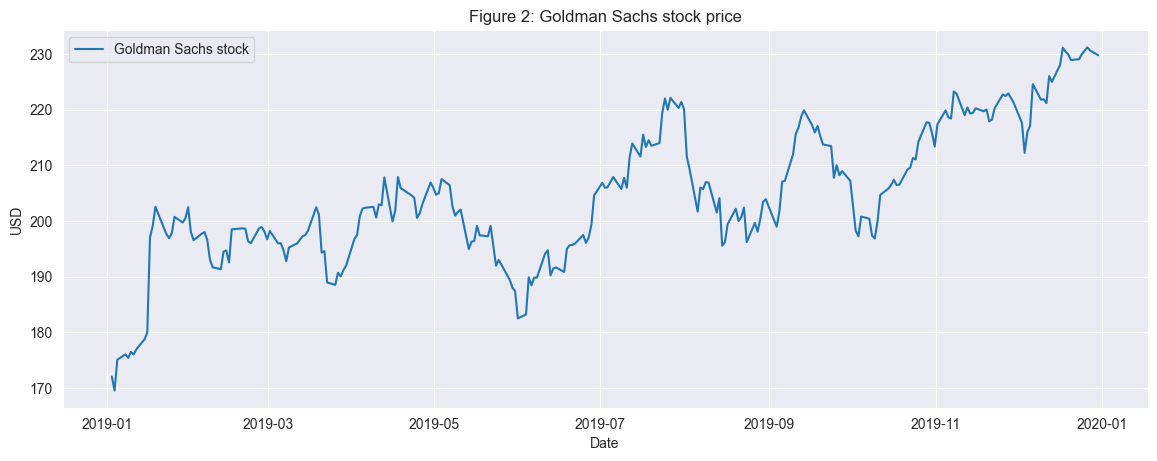

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(basic_golden_df['Date'], basic_golden_df['Close'], label='Goldman Sachs stock')
#plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()


In [7]:
num_training_days = int(basic_golden_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    basic_golden_df.shape[0]-num_training_days))

Number of training days: 175. Number of test days: 76.


## Techincal Indicators

In [8]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [9]:
basic_TI_df = get_technical_indicators(basic_golden_df)
basic_TI_df.tail()

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
246,2019-12-23 16:00:00,229.66,230.48,228.41,229.09,1671705,228.942857,223.375238,223.394722,226.662372,3.267651,5.210045,233.795328,212.955148,229.159225,228.09
247,2019-12-24 13:00:00,228.98,229.95,228.37,229.91,467722,229.644286,223.833810,223.877335,227.162007,3.284673,5.396293,234.626395,213.041224,229.659742,228.91
248,2019-12-26 16:00:00,230.26,232.20,229.99,231.21,1704161,230.097143,224.236667,224.420495,227.784776,3.364280,5.624133,235.484932,212.988401,230.693247,230.21
249,2019-12-27 16:00:00,231.81,232.21,230.47,230.66,1343887,230.027143,224.627619,224.882681,228.227118,3.344437,5.786738,236.201096,213.054143,230.671082,229.66
250,2019-12-30 16:00:00,231.68,231.68,229.50,229.80,1494667,229.934286,224.953810,225.246927,228.469100,3.222173,5.836651,236.627112,213.280507,230.090361,228.80


In [10]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()


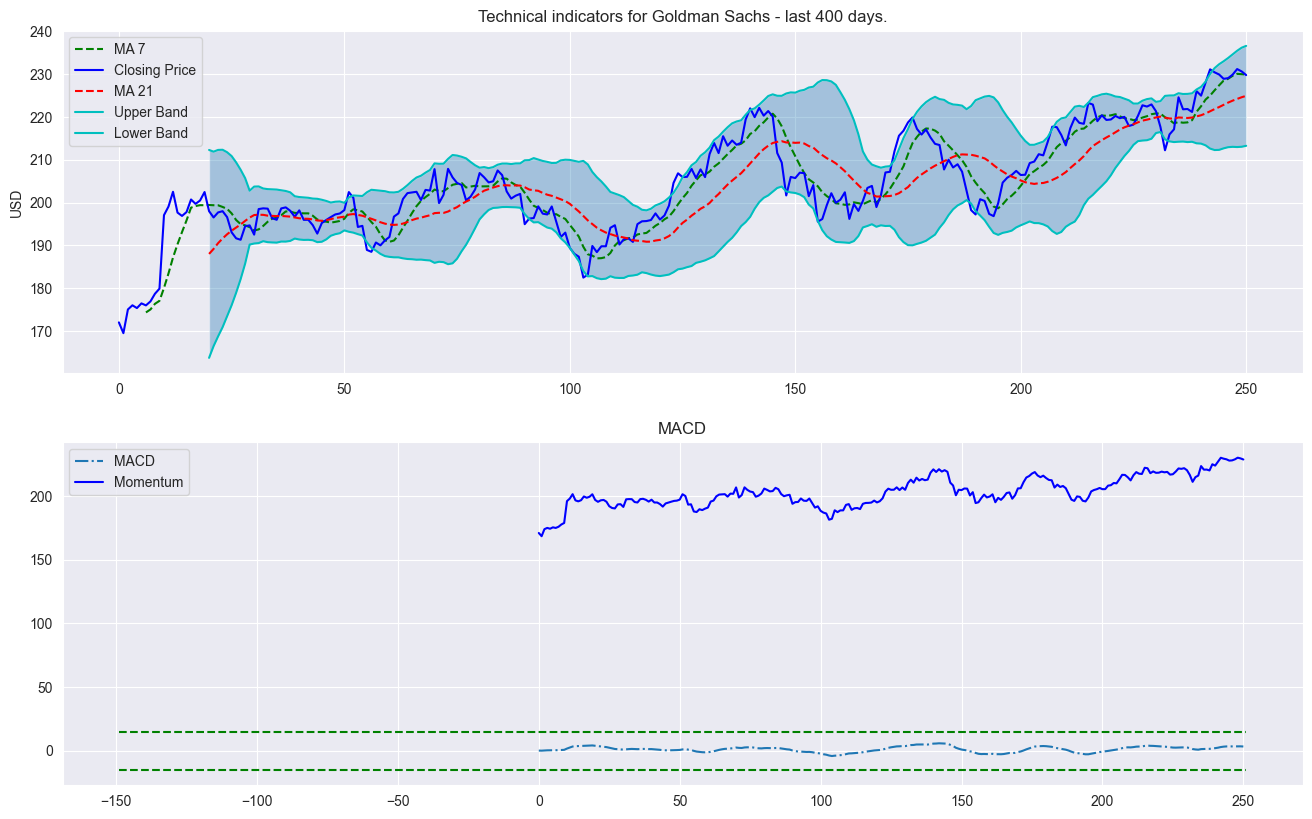

In [11]:
plot_technical_indicators(basic_TI_df, 400)

## Sentiment Analysis 
https://www.youtube.com/watch?v=szczpgOEdXs

In [12]:
fft_df

NameError: name 'fft_df' is not defined

# Fourier Transforms

In [13]:
data_FT = basic_TI_df[['Date', 'Close']]

In [14]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


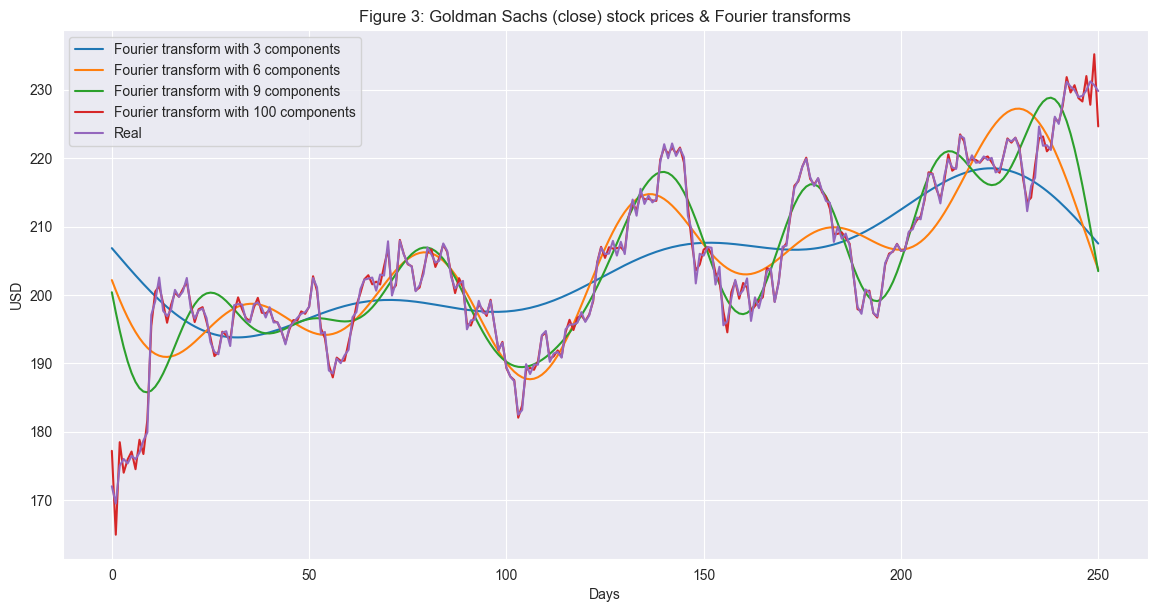

In [15]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

# ARIMA Prediction

In [15]:

from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -625.918
Date:                Mon, 11 Jul 2022   AIC                           1263.837
Time:                        16:43:10   BIC                           1284.966
Sample:                             0   HQIC                          1272.341
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0141      0.076     -0.186      0.852      -0.163       0.135
ar.L2          0.0248      0.058      0.429      0.668      -0.088       0.138
ar.L3         -0.0236      0.066     -0.359      0.7

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


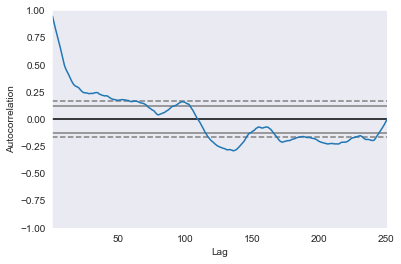

<Figure size 800x560 with 0 Axes>

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [17]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [18]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6.986


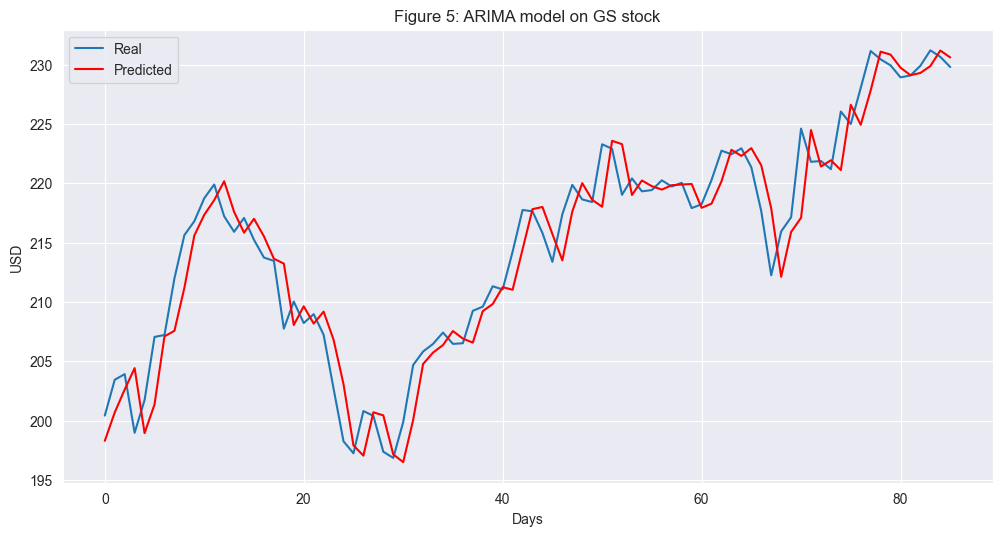

In [19]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

As observed, the ARIMA models still predicts with high-fidelity even without sentiment analysis – 
an interssting concept philosophically. – I wonder why the peaks and throughs are off by about 2 days. 
Could sentiment analysis bring it closer to acctuality? I also wonder if the scale on Boris's model 
just blurred this slight discrepency. Next I will try with more data and for the 2022 fiscal year, 
which has been more unpredictable. Overall, very promising results! Thank you again, Boris.


# Using 10yrs of data to predict in this uncertain time (2022)

In [4]:
def parser(x):
    return pd.to_datetime(x, infer_datetime_format=True)

In [5]:
ten_golden_df = pd.read_excel('../Documents/stock_data_trial.xlsx',
                    sheet_name=1,
                    parse_dates=[0],
                    skiprows = 0,
                    usecols = ['Date', 'Close'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

ten_golden_df.set_index(['Date'])
ten_golden_df.dropna(axis=0, inplace=True) 

#ten_golden_df.columns
ten_golden_df.tail(10)

,Date,Close
2383,2022-06-21 16:00:00,284.81
2384,2022-06-22 16:00:00,284.54
2385,2022-06-23 16:00:00,286.17
2386,2022-06-24 16:00:00,302.75
2387,2022-06-27 16:00:00,300.78
2388,2022-06-28 16:00:00,299.49
2389,2022-06-29 16:00:00,303.28
2390,2022-06-30 16:00:00,297.02
2391,2022-07-01 16:00:00,299.23
2392,2022-07-05 16:00:00,297.20


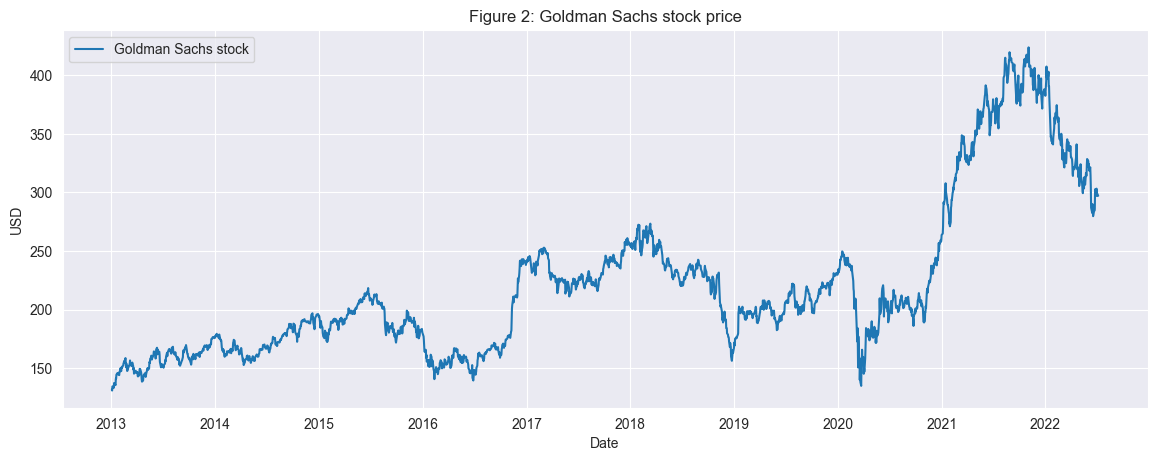

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(ten_golden_df['Date'], ten_golden_df['Close'], label='Goldman Sachs stock')
#plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()


In [7]:
num_training_days = int(ten_golden_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    ten_golden_df.shape[0]-num_training_days))

Number of training days: 1675. Number of test days: 718.


## Technical Indicators

In [7]:

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

ten_TI_df = get_technical_indicators(ten_golden_df)
ten_TI_df.head()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2013-01-02 16:00:00,131.66,NaN,NaN,131.660000,131.660000,0.000000,NaN,NaN,NaN,131.660000,130.66
1,2013-01-03 16:00:00,130.94,NaN,NaN,131.286154,131.270000,-0.016154,NaN,NaN,NaN,131.120000,129.94
2,2013-01-04 16:00:00,134.51,NaN,NaN,132.444450,132.534573,0.090122,NaN,NaN,NaN,133.466923,133.51
3,2013-01-07 16:00:00,134.26,NaN,NaN,132.951999,133.079223,0.127224,NaN,NaN,NaN,134.002250,133.26
4,2013-01-08 16:00:00,133.05,NaN,NaN,132.974726,133.071283,0.096557,NaN,NaN,NaN,133.364793,132.05


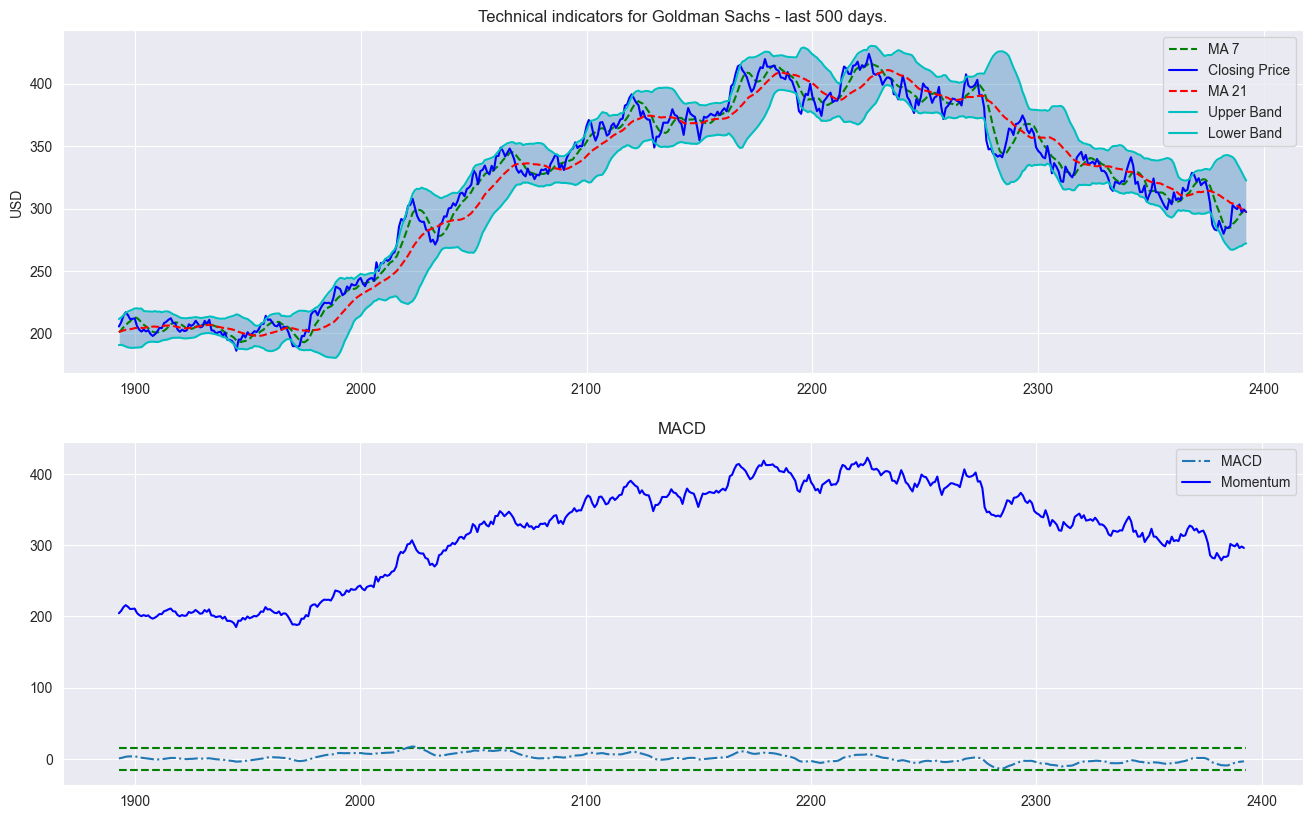

In [8]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
    
plot_technical_indicators(ten_TI_df, 500)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


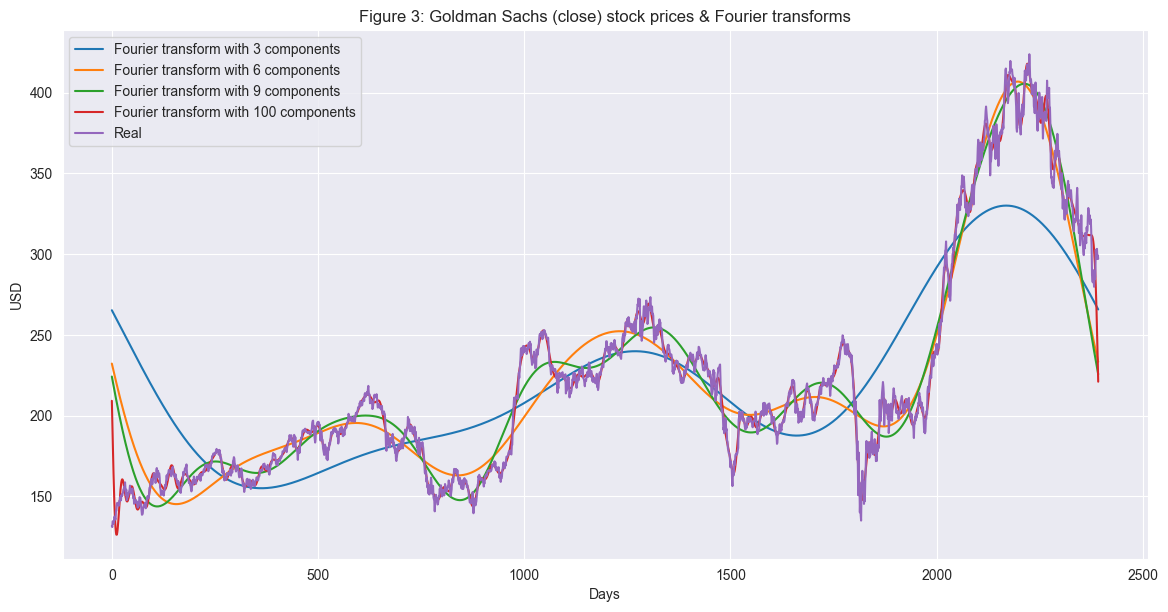

In [9]:
ten_data_FT = ten_TI_df[['Date', 'Close']]

close_fft = np.fft.fft(np.asarray(ten_data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))


plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(ten_data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [10]:
#ten_data_FT.head()
#fft_df.head()
ten_TI_df.tail()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2388,2022-06-28 16:00:00,299.49,291.190000,302.256667,300.793022,295.369513,-5.423509,16.839742,335.936151,268.577182,299.501757,298.49
2389,2022-06-29 16:00:00,303.28,294.545714,301.051905,300.977243,296.586511,-4.390732,15.718503,332.488911,269.614899,302.020586,302.28
2390,2022-06-30 16:00:00,297.02,296.290000,299.631429,300.684114,296.653202,-4.030912,14.838016,329.307461,269.955396,298.686862,296.02
2391,2022-07-01 16:00:00,299.23,298.388571,298.554286,300.576401,297.049632,-3.526769,13.553721,325.661728,271.446843,299.048954,298.23
2392,2022-07-05 16:00:00,297.20,299.964286,297.266190,300.326298,297.072766,-3.253532,12.584221,322.434632,272.097749,297.816318,296.20


## ARIMA 

See if just making the whole train data projects to future - i.e. project forward

In [11]:
#https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6 
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = ten_TI_df['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2393
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6639.807
Date:                Mon, 25 Jul 2022   AIC                          13291.613
Time:                        20:11:52   BIC                          13326.293
Sample:                             0   HQIC                         13304.232
                               - 2393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0102      0.011     -0.899      0.369      -0.033       0.012
ar.L2          0.0416      0.013      3.145      0.002       0.016       0.068
ar.L3         -0.0193      0.014     -1.411      0.1

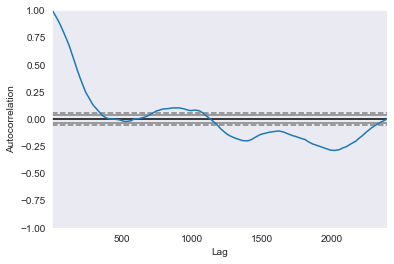

<Figure size 800x560 with 0 Axes>

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [14]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# X is a series of the prices of stock
series = ten_TI_df['Close']
X = series.values

#size is 2/3 of X, train is all of size (2/3 of prices), test is the remainig 1/3
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

#History is a list starting at train (I think) predicitons is a list
history = [x for x in train]
predictions = list()

#for every day in test, predict an "observation" for that day and add it to the lists
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
### More research is needed, but I might be able to just forcast to a determined amount of days 
###using "test" as a numerical vector and all of the train data as train

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [22]:
    error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 30.043


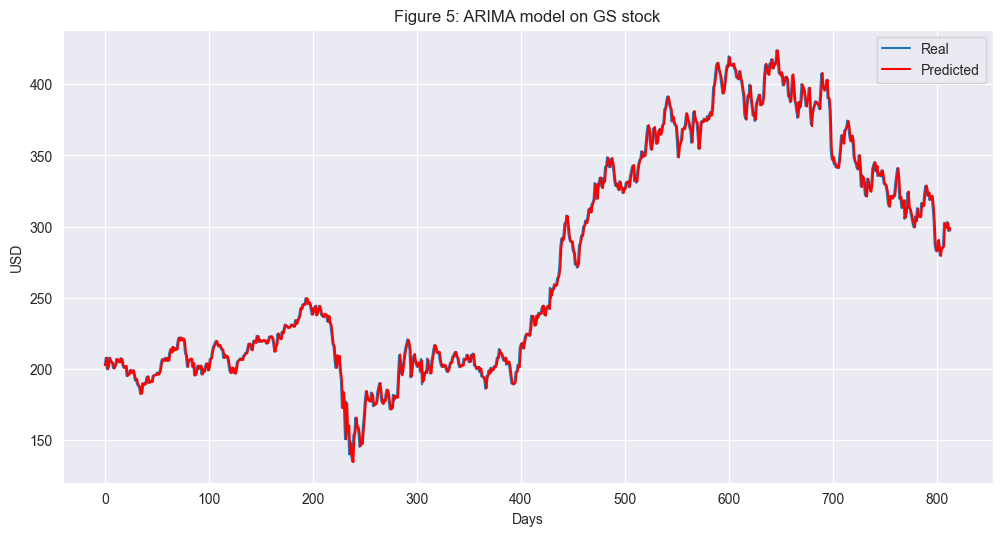

In [23]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

With this data, a very accurate prediciton of the data was preduced even though the market has been very unpredictaable – highly promising results. Next is to figure out how to forecast, add other features that might boost accuraccy, (sentiment, SARIMAX, etc.). I will also validate with another stock, and try different kinds - penny, ETF, options, etc.

## Other Stock Validation

In [10]:
curlf_golden_df = pd.read_excel('../Documents/stock_data_trial.xlsx',
                    sheet_name=2,
                    parse_dates=[0],
                    skiprows = 0,
                    usecols = ['Date', 'Close'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

curlf_golden_df.set_index(['Date'])
curlf_golden_df.dropna(axis=0, inplace=True) 

#curlf_golden_df.columns
curlf_golden_df.tail()

,Date,Close
921,2022-06-28,5.27
922,2022-06-29,5.07
923,2022-06-30,5.05
924,2022-07-01,5.00
925,2022-07-05,5.22


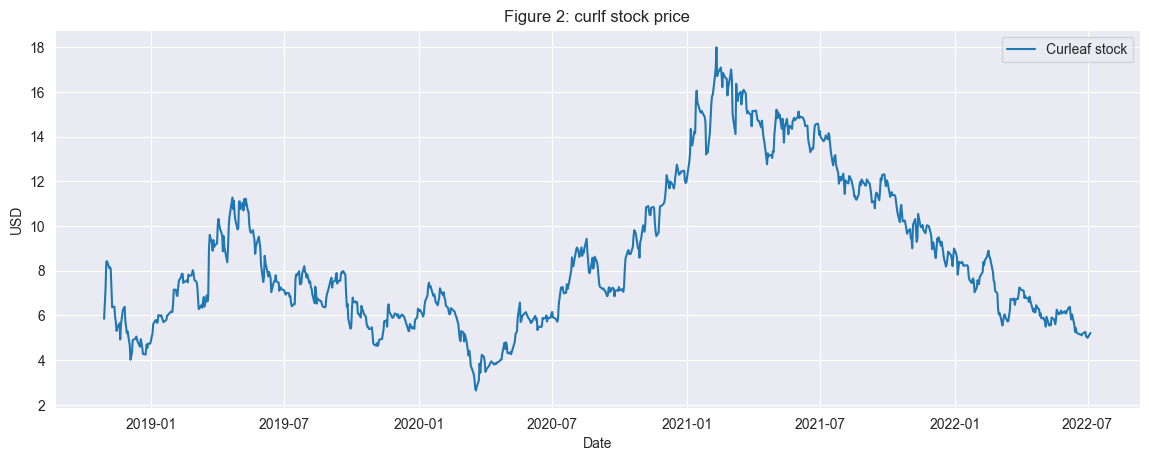

In [13]:

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(curlf_golden_df['Date'], curlf_golden_df['Close'], label='Curleaf stock')
#plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: curlf stock price')
plt.legend()
plt.show()



In [14]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

curlf_TI_df = get_technical_indicators(curlf_golden_df)
curlf_TI_df.head()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2018-10-29,5.85,NaN,NaN,5.850000,5.850000,0.000000,NaN,NaN,NaN,5.850000,4.85
1,2018-10-30,6.56,NaN,NaN,6.218654,6.234583,0.015929,NaN,NaN,NaN,6.382500,5.56
2,2018-10-31,7.21,NaN,NaN,6.574835,6.615289,0.040454,NaN,NaN,NaN,6.955385,6.21
3,2018-11-01,8.41,NaN,NaN,7.087867,7.181809,0.093942,NaN,NaN,NaN,7.937250,7.41
4,2018-11-02,8.43,NaN,NaN,7.399113,7.520938,0.121825,NaN,NaN,NaN,8.267107,7.43


In [15]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = curlf_TI_df['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  926
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -339.212
Date:                Fri, 15 Jul 2022   AIC                            690.425
Time:                        18:09:09   BIC                            719.403
Sample:                             0   HQIC                           701.480
                                - 926                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0630      0.026      2.411      0.016       0.012       0.114
ar.L2         -0.0244      0.029     -0.838      0.402      -0.081       0.033
ar.L3         -0.0693      0.025     -2.814      0.0

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [16]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# X is a series of the prices of stock
series = curlf_TI_df['Close']
X = series.values

#size is 2/3 of X, train is all of size (2/3 of prices), test is the remainig 1/3
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

#History is a list starting at train (I think) predicitons is a list
history = [x for x in train]
predictions = list()

#for every day in test, predict an "observation" for that day and add it to the lists
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
### More research is needed, but I might be able to just forcast to a determined amount of days 
###using "test" as a numerical vector and all of the train data as train

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


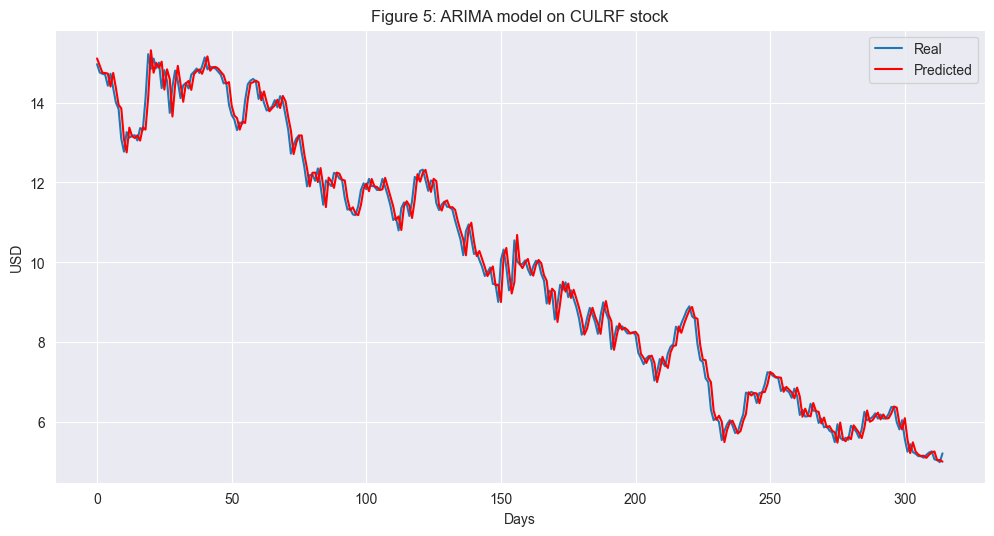

In [17]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on CULRF stock')
plt.legend()
plt.show()

The Boris pipeline appears applicable to a more volitile stock (CURLF) and accurately predicted a downtrend that grandpa and I did not forsee – giving the model more value

# Predicting ARIMA
- Alright, a point of semantics - .forecast() means to compare generated data points with the test date, .Predict() means to project data into the future

- might be the predict fxn, might just be messing with the test, train - more research needed, 
also creating the def will be huge.
Last piece of the puzzle before real-world testing

#####Everything hinges on geting the time series to load in to .predicct()

In [13]:
 ten_TI_df.tail()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2388,2022-06-28 16:00:00,299.49,291.190000,302.256667,300.793022,295.369513,-5.423509,16.839742,335.936151,268.577182,299.501757,298.49
2389,2022-06-29 16:00:00,303.28,294.545714,301.051905,300.977243,296.586511,-4.390732,15.718503,332.488911,269.614899,302.020586,302.28
2390,2022-06-30 16:00:00,297.02,296.290000,299.631429,300.684114,296.653202,-4.030912,14.838016,329.307461,269.955396,298.686862,296.02
2391,2022-07-01 16:00:00,299.23,298.388571,298.554286,300.576401,297.049632,-3.526769,13.553721,325.661728,271.446843,299.048954,298.23
2392,2022-07-05 16:00:00,297.20,299.964286,297.266190,300.326298,297.072766,-3.253532,12.584221,322.434632,272.097749,297.816318,296.20


In [10]:
#series = ten_data_FT['Close']
#model = ARIMA(series, order=(5, 1, 0))
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

ARIMA_model = pm.auto_arima(ten_data_FT['Close'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [11]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = ARIMA_model

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

In [14]:
for new_ob in test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
print(f"SMAPE: {smape(test, forecasts)}")

Mean squared error: 40.65307616707616
SMAPE: 1.588031153945339


In [4]:
#forecasts

AttributeError: 'numpy.ndarray' object has no attribute 'index'

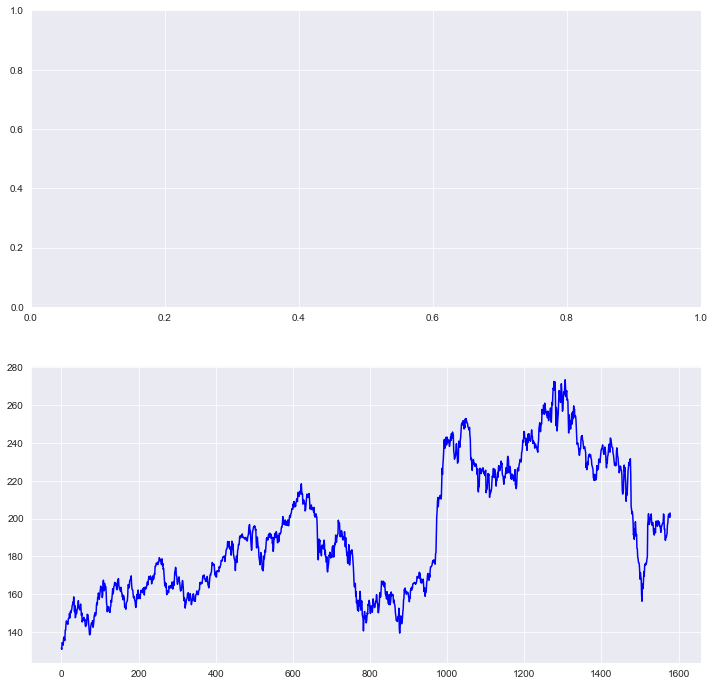

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Training Data')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

Pretty crude, but promising

## Predicting from current date
- Use all data available to .predict()
- main issue is that I will need an index to put the forcasted data into
- this is the last piece!

- I fucking had it before messing with the CI, essentially I passed the index of the whole whole train 
to the ARIMA model so that it had a couple thousand predicitons off the end, then plotted the predicitons with the train because they had the same scale. I saw the tell-tale peak and then the sharp crash which "should" happen sometime soon, distinctly different than the train data

- the new forcaast is starting at the beginning of the data, not where the train leaves off - this is the check and it's what I used to make sure the good try worked because it started the same as the validation forcast above but extended further ####look at note under last graph###


In [12]:
#series = ten_data_FT['Close']
#model = ARIMA(series, order=(5, 1, 0))
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

ARIMA_model = pm.auto_arima(ten_data_FT['Close'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [13]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = ARIMA_model

def forecast_30_step():
    fc, conf_int = model.predict(n_periods=1000, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

deep_end_forecasts = []
deep_end_confidence_intervals = []

In [14]:
for new_ob in train:
    fc, conf = forecast_30_step()
    deep_end_forecasts.append(fc)
    deep_end_confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
#print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
#print(f"SMAPE: {smape(test, forecasts)}")

NameError: name 'train' is not defined

In [5]:
#forecasts

AttributeError: 'numpy.ndarray' object has no attribute 'index'

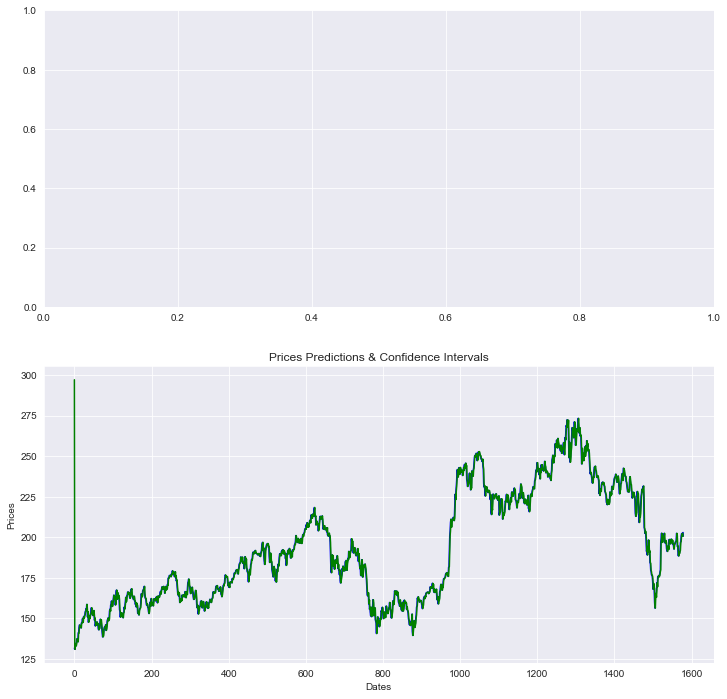

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Training Data')
axes[1].plot(deep_end_forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(train.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

### Notes on prediction
 - Statsmodels ARIMAResults might be better than pmdarima for OUT OF SAMPLE forcasts:
https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html?highlight=predict#statsmodels.tsa.arima.model.ARIMAResults.predicthttps://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html?highlight=predictdict


- statsmodels .get_forcast() and .get_predictions() looks promising can also get CI from the fxn, 
.forecast() can deliver df 
https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html#statsmodels.tsa.arima.model.ARIMAResults.get_forecast


- run to see if a straight method can get out of sample forcasting, may need to use a "date-only" series for the loop
to get it to go beyond the sample

- out of sample examples
https://machinelearningmastery.com/make-sample-forecasts-arima-python/
https://s3.amazonaws.com/assets.datacamp.com/production/course_17329/slides/chapter2.pdf
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3


In [41]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = ten_TI_df['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
forcast = model_fit.get_prediction(start=-25, steps = 30)


#print(model_fit.summary())

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [43]:
forcast

AttributeError: 'PredictionResults' object has no attribute 'head'

TypeError: float() argument must be a string or a number, not 'PredictionResultsWrapper'

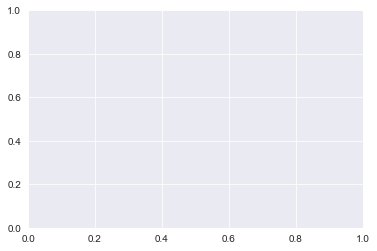

In [46]:
plt.figure()
# Plot prediction
plt.plot(forcast, color='red',label='forecast')

# Shade uncertainty area
#plt.fill_between(dates, lower_limits, upper_limits, color=
#'pink')
#plt.show()

In [37]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error

# X is a series of the prices of stock
series = ten_TI_df['Close']
#X = series.values

#size is 2/3 of X, train is all of size (2/3 of prices), test is the remainig 1/3
#size = int(len(X) * 0.66)
#train, test = X[0:size], X[size:len(X)]

#History is a list starting at train (I think) predicitons is a list
#history = [x for x in train]
#predictions = list()

#for every day in test, predict an "observation" for that day and add it to the lists
#for t in range(len(series)):
    
#model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast(steps=30)
#yhat = output[0]
#predictions.append(yhat)
#obs = test[t]
#history.append(obs)
    

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [38]:
predictions

[202.9282543989135,
 202.82738772749784,
 207.97853691316544,
 199.90294358086445,
 201.6777494428006,
 207.79354902584276,
 205.95427198575615,
 204.9377100480471,
 203.85603846925483,
 200.2634076577962,
 201.50102522967865,
 203.14419532218682,
 207.11034374277855,
 206.09505392710602,
 204.65235797992085,
 204.78901825190823,
 207.3958661511543,
 206.51772818698655,
 202.6461399127951,
 200.8146221000842,
 201.51481135562818,
 202.19949460308953,
 195.1063835483989,
 196.3109887189653,
 196.3095330777747,
 199.33829632723445,
 197.71334712917755,
 197.18425473178166,
 199.04547324123234,
 195.41660222669336,
 192.0060383702446,
 192.92758958525295,
 189.3847482981344,
 188.27068510095182,
 187.45556359316075,
 182.46005815487015,
 183.34504172322607,
 189.98922454711948,
 188.6165160412751,
 190.08936337599658,
 189.596359458701,
 193.9126007150767,
 194.79124670965334,
 190.15963878442375,
 191.3463713788317,
 191.41711719943527,
 190.91783549107913,
 195.18360624654247,
 195.5939

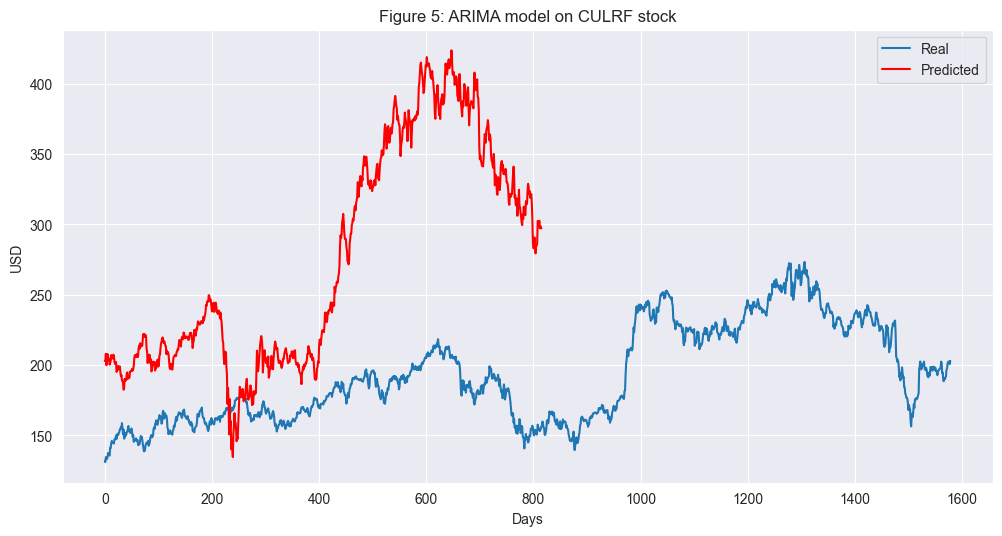

In [39]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on CULRF stock')
plt.legend()
plt.show()

,fft,absolute,angle
0,51279.000049+0.000000j,51279.490000,1.662753e-18
1,277.735587+1066.612498j,1102.179331,1.316063e+00
2,77.277906+0459.9180220j,466.365159,1.404326e+00
3,-72.642464+0924.6147570j,927.463949,1.649200e+00
4,-45.0324220-29.1978530j,53.669672,-2.566361e+00
...,...,...,...
246,-534.880041-622.529905j,820.755835,-2.280609e+00
247,-45.0324220+29.1978530j,53.669672,2.566361e+00
248,-72.642464-0924.6147570j,927.463949,-1.649200e+00
249,77.277906-0459.9180220j,466.365159,-1.404326e+00


In [21]:
basic_TI_df.head(1)

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2019-01-02 16:00:00,164.33,172.25,163.35,172.03,3999444,NaN,NaN,172.03,172.03,0.0,NaN,NaN,NaN,172.03,171.03


In [22]:
basic_golden_df.head(1)

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2019-01-02 16:00:00,164.33,172.25,163.35,172.03,3999444,NaN,NaN,172.03,172.03,0.0,NaN,NaN,NaN,172.03,171.03


Look at the for loop, I basically appended the new predicitions on the old ones for train. 
However, looking at this data, I see that the appended are just two very well forcasted train data sets
linked onto a test data set prediciton... this looks similar to the one I was excited about, but I'm probably back 
at square one...

In [22]:
merge1_df = pd.merge(basic_golden_df, basic_TI_df, on=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

fft_df['tmp'] = 1
merge1_df['tmp'] = 1

merged_df = pd.merge(merge1_df, fft_df, on=['tmp'])
merged_df = merged_df.drop('tmp', axis=1)

merged_df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ma7_x', 'ma21_x',
       '26ema_x', '12ema_x', 'MACD_x', '20sd_x', 'upper_band_x',
       'lower_band_x', 'ema_x', 'momentum_x', 'ma7_y', 'ma21_y', '26ema_y',
       '12ema_y', 'MACD_y', '20sd_y', 'upper_band_y', 'lower_band_y', 'ema_y',
       'momentum_y', 'fft', 'absolute', 'angle'],
      dtype='object')

KeyError: 'ma7'

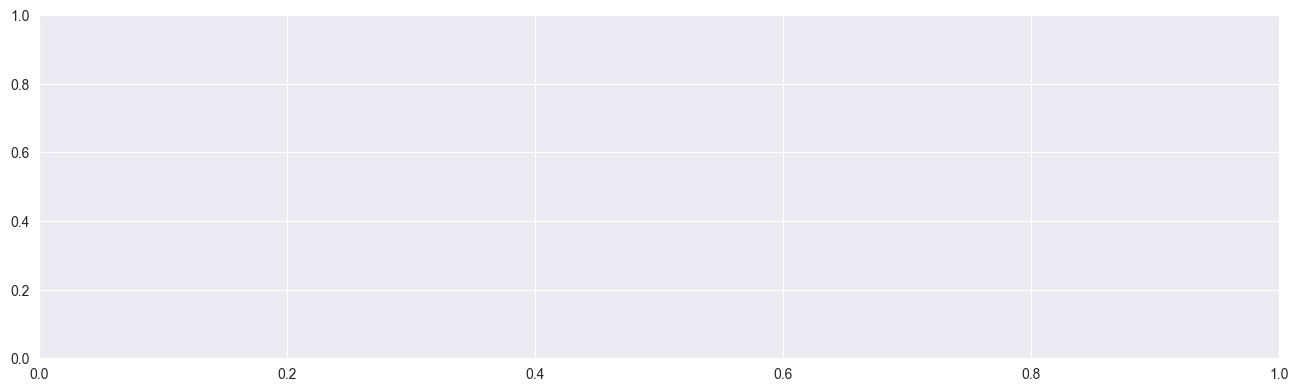

In [21]:
plot_technical_indicators(merged_df, 400)